In [ ]:
import numpy as np
import pandas as pd
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [105]:
image_directory_path = '/home/ptiyaja/Documents/Fundus/train'
excel_path = '/home/ptiyaja/Documents/Fundus/train model.xlsx'
pd.read_excel(excel_path)

,image,CDR,VB,TC,PPAN,PPAT,LC,notch,DH,saucerization,Glaucoma,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1ffa94a2-8d87-11e8-9daf-6045cb817f5b..JPG,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
1,1ffa94a5-8d87-11e8-9daf-6045cb817f5b..JPG,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,1ffa94a8-8d87-11e8-9daf-6045cb817f5b..JPG,0.0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,1ffa94b7-8d87-11e8-9daf-6045cb817f5b..JPG,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,1ffa94b8-8d87-11e8-9daf-6045cb817f5b..JPG,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,NL_155.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
355,NL_157.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
356,NL_159.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
357,NL_160.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


# Dataset Class for Predicting Biomarkers

In [184]:
class FundusBiomarkerDataset(Dataset):
    def __init__(self, image_directory_path, excel_path, resolution=224, augmentation=False):
        
        if image_directory_path is None and excel_path is None:
            return
        
        dataframe = pd.read_excel(excel_path)
        
        self.fundus_images = np.empty((len(dataframe['image']), 3, resolution, resolution), dtype='float32')                                                       # Stores resized fundus images
        self.biomarker_labels = [name for name in pd.read_excel(excel_path).columns.tolist() if not name.split()[0] in ['image', 'Glaucoma', 'Unnamed:']]          # Stores names for the biomarkers
        self.biomarker_vector = np.empty((len(dataframe['image']), len(self.biomarker_labels)), dtype='float32')                                                   # Stores one-hot vector for biomarkers
        
        fundus_idx = 0
        for row_idx, image_name in enumerate(tqdm(dataframe['image'], desc='Loading Images')):
            
            # Read image
            if not isinstance(image_name, str):
                print(f'Invalid image name at row {row_idx + 2}')
                continue
            image_path = os.path.join(image_directory_path, image_name)
            try:
                fundus_image = cv2.imread(image_path)
            except:
                print(f'Error reading image {image_name}')
                continue
            
            # Resize image
            resized_fundus_image = cv2.resize(fundus_image, (resolution, resolution), interpolation=cv2.INTER_AREA)
            if np.max(resized_fundus_image) > 1:
                resized_fundus_image = resized_fundus_image.astype('float32') / 255
            self.fundus_images[fundus_idx] = np.transpose(resized_fundus_image)
            
            # Read biomarker. If value contains comment, only read the first character.
            biomarker_vector_list = [dataframe[label][row_idx][0] == 1 if isinstance(dataframe[label][row_idx], str) else dataframe[label][row_idx] == 1 for label in self.biomarker_labels]
            self.biomarker_vector[fundus_idx] = np.asarray(biomarker_vector_list)
            
            fundus_idx += 1
        
        # Convert to torch tensors (type of arrays that can be run with neural networks)
        self.fundus_images = torch.tensor(self.fundus_images[:fundus_idx], dtype=torch.float32)
        self.biomarker_vector = torch.tensor(self.biomarker_vector[:fundus_idx], dtype=torch.float32)
        
    def __len__(self):
        return self.fundus_images.shape[0]
    
    def __getitem__(self, idx):
        return self.fundus_images[idx], self.biomarker_vector[idx]
    
    def split_train_test(self, train_test_ratio, seed=0):
        split_indices = np.arange(0, self.__len__())
        np.random.shuffle(split_indices)
        
        split_index = int(self.__len__() * train_test_ratio)
        
        train_dataset = FundusBiomarkerDataset(image_directory_path=None, excel_path=None)
        test_dataset = FundusBiomarkerDataset(image_directory_path=None, excel_path=None)
        
        train_dataset.fundus_images = self.fundus_images[:split_index]
        train_dataset.biomarker_vector = self.biomarker_vector[:split_index]
        train_dataset.biomarker_labels = self.biomarker_labels
        
        test_dataset.fundus_images = self.fundus_images[split_index:]
        test_dataset.biomarker_vector = self.biomarker_vector[split_index:]
        test_dataset.biomarker_labels = self.biomarker_labels
        
        return train_dataset, test_dataset
    
    
    
fundus_biomarker_dataset = FundusBiomarkerDataset(image_directory_path, excel_path)
train_fundus_biomarker_dataset, test_fundus_biomarker_dataset = fundus_biomarker_dataset.split_train_test(0.8)

Loading Images:  60%|█████▉    | 214/359 [00:03<00:02, 62.58it/s] 

Invalid image name at row 201
Invalid image name at row 202
Invalid image name at row 203
Invalid image name at row 204
Invalid image name at row 205
Invalid image name at row 206
Invalid image name at row 207
Invalid image name at row 208
Invalid image name at row 209


Loading Images: 100%|██████████| 359/359 [00:07<00:00, 46.07it/s]


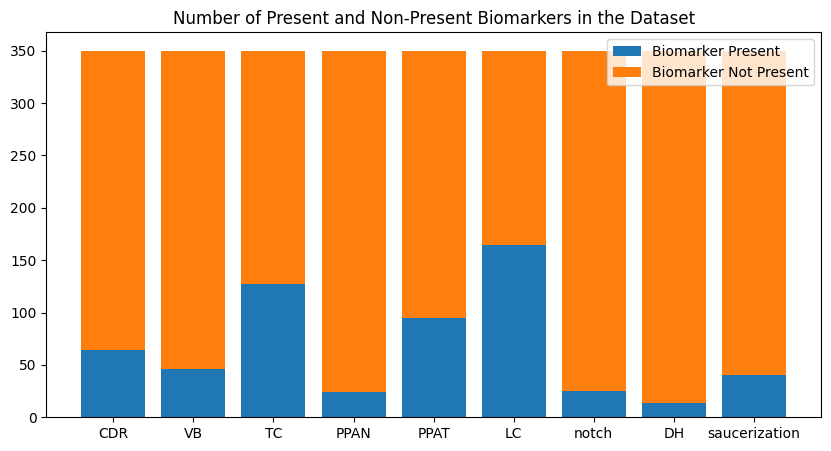

In [185]:
biomarkers_present = fundus_biomarker_dataset[:][1].numpy().sum(axis=0)
biomarkers_not_present = fundus_biomarker_dataset[:][1].numpy().shape[0] - fundus_biomarker_dataset[:][1].numpy().sum(axis=0)

plt.figure(figsize=(10, 5))
plt.title('Number of Present and Non-Present Biomarkers in the Dataset')
plt.bar(fundus_biomarker_dataset.biomarker_labels, biomarkers_present, label='Biomarker Present')
plt.bar(fundus_biomarker_dataset.biomarker_labels, biomarkers_not_present, bottom=biomarkers_present, label='Biomarker Not Present')
plt.legend()

# Custom Models for Biomarker Predictions
Here we modify a popular neural network architecture that is common for image classification tasks. The architecture consists of feature extraction layers and classification layers. The former extracts information from the images and the latter uses these information to predict the image's classification. Since our dataset is limited, we can leverage pre-trained models that were trained on huge amount of images where the feature extraction part of the model is already well-trained. Using outputs from the pre-trained feature extraction layers, we feed these to our own layers which we will train them to predict biomarkers.

In [186]:
# Custom class based on ResNet. 
class ResNetBiomarker(nn.Module):
    def __init__(self, num_biomarkers, resnet_version='resnet18', pretrained=True, fc_layer_size=128, num_fc_layers=3, dropout=0.3):
        super(ResNetBiomarker, self).__init__()
        
        # Download resnet from the internet
        self.resnet_version = resnet_version
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', resnet_version, pretrained=pretrained)
        
        in_features = self.resnet.fc.in_features
        
        # Create our own layers and append to original resnet model
        layers = []
        prev_features = in_features
        
        for idx in range(num_fc_layers):
            layers.append(nn.Linear(prev_features, fc_layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_features = fc_layer_size
            
        layers.append(nn.Linear(prev_features, num_biomarkers))
        layers.append(nn.Sigmoid())
        
        self.resnet.fc = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.resnet(x)

We can vary different parameters of this model to find a combination that suits our problem the best. We call these "hyperparameters". For our model, we can adjust the following values:
### Dataset Hyperparameters
- `resolution`: Use larger image input size. Bigger -> more information but also increases complexity
### Model Hyperparameters
- `resnet_version`: resnet18, resnet34, resnet50, resnet101, resnet152

- `pretrained`: True / False

- `fc_layer_size`: The width of our classification layers. Higher number = more complex model.

- `num_fc_layers`: The depth of our classification layers. Higher number = more complex model.

- `dropout`: 0 - 1
### Learning Hyperparameters
- `learning_rate`

In [190]:
resnet_biomarker_model = ResNetBiomarker(
    num_biomarkers = len(fundus_biomarker_dataset[0][1]),
    resnet_version = 'resnet101',
    pretrained=True, 
    fc_layer_size=128, 
    num_fc_layers=1, 
    dropout=0.2
)
for name, param in resnet_biomarker.named_parameters():
    if 'fc' not in name:
        resnet_biomarker.requires_grad = False
        
resnet_biomarker

Using cache found in /home/ptiyaja/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/ptiyaja/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 117MB/s] 


ResNetBiomarker(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

# Training the Model

In [191]:
learning_rate = 0.01
batch_size = 8
num_epochs = 100

# Define Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

criterion = nn.BCEWithLogitsLoss()  # Binary multi-label loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_fundus_biomarker_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_fundus_biomarker_dataset, batch_size=batch_size, shuffle=False)

resnet_biomarker_model = resnet_biomarker_model.to(device)

Using device: cuda


In [192]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training Loop
for epoch in range(num_epochs):
    resnet_biomarker_model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convert labels to float

        optimizer.zero_grad()  # Zero the gradients
        outputs = resnet_biomarker_model(images)  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Compute training accuracy (multi-label binary classification)
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.numel()  # Total elements in batch

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train  # Overall training accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation Loop
    resnet_biomarker_model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = resnet_biomarker_model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            correct_val += (preds == labels).sum().item()
            total_val += labels.numel()

    avg_val_loss = val_loss / len(test_loader)
    val_acc = correct_val / total_val  # Overall validation accuracy
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Print Epoch Results
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


Epoch [1/100] | Train Loss: 0.8749 | Train Acc: 0.4004 | Val Loss: 0.9308 | Val Acc: 0.3603
Epoch [2/100] | Train Loss: 0.8746 | Train Acc: 0.4139 | Val Loss: 0.9318 | Val Acc: 0.3333
Epoch [3/100] | Train Loss: 0.8745 | Train Acc: 0.4091 | Val Loss: 0.9316 | Val Acc: 0.3429
Epoch [4/100] | Train Loss: 0.8745 | Train Acc: 0.4060 | Val Loss: 0.9316 | Val Acc: 0.3444
Epoch [5/100] | Train Loss: 0.8746 | Train Acc: 0.3972 | Val Loss: 0.9318 | Val Acc: 0.3333
Epoch [6/100] | Train Loss: 0.8746 | Train Acc: 0.3956 | Val Loss: 0.9322 | Val Acc: 0.3349
Epoch [7/100] | Train Loss: 0.8744 | Train Acc: 0.4075 | Val Loss: 0.9320 | Val Acc: 0.3333
Epoch [8/100] | Train Loss: 0.8747 | Train Acc: 0.4012 | Val Loss: 0.9320 | Val Acc: 0.3270
Epoch [9/100] | Train Loss: 0.8744 | Train Acc: 0.4056 | Val Loss: 0.9321 | Val Acc: 0.3349
Epoch [10/100] | Train Loss: 0.8748 | Train Acc: 0.3968 | Val Loss: 0.9319 | Val Acc: 0.3492
Epoch [11/100] | Train Loss: 0.8746 | Train Acc: 0.4052 | Val Loss: 0.9318 | Va

KeyboardInterrupt: 